In [1]:
import numpy as np
import tensorflow as tf

# Configuration paramaters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 100

In [2]:
import chess
def filter_legal_moves(board,logits):
    filter_mask = np.zeros(logits.shape)
    legal_moves = board.legal_moves
    for legal_move in legal_moves:
        from_square = legal_move.from_square
        to_square = legal_move.to_square
        idx = move2num[chess.Move(from_square,to_square)]
        filter_mask[idx] = 1
    new_logits = logits*filter_mask
    return new_logits

num2move = {}
move2num = {}
counter = 0
for from_sq in range(64):
    for to_sq in range(64):
        num2move[counter] = chess.Move(from_sq,to_sq)
        move2num[chess.Move(from_sq,to_sq)] = counter
        counter += 1

def translate_board(board): 
    pgn = board.epd()
    foo = []  
    pieces = pgn.split(" ", 1)[0]
    rows = pieces.split("/")
    for row in rows:
        foo2 = []  
        for thing in row:
            if thing.isdigit():
                for i in range(0, int(thing)):
                    foo2.append(chess_dict['.'])
            else:
                foo2.append(chess_dict[thing])
        foo.append(foo2)
    return np.array(foo)

chess_dict = {
    'p' : [1,0,0,0,0,0,0,0,0,0,0,0],
    'P' : [0,0,0,0,0,0,1,0,0,0,0,0],
    'n' : [0,1,0,0,0,0,0,0,0,0,0,0],
    'N' : [0,0,0,0,0,0,0,1,0,0,0,0],
    'b' : [0,0,1,0,0,0,0,0,0,0,0,0],
    'B' : [0,0,0,0,0,0,0,0,1,0,0,0],
    'r' : [0,0,0,1,0,0,0,0,0,0,0,0],
    'R' : [0,0,0,0,0,0,0,0,0,1,0,0],
    'q' : [0,0,0,0,1,0,0,0,0,0,0,0],
    'Q' : [0,0,0,0,0,0,0,0,0,0,1,0],
    'k' : [0,0,0,0,0,1,0,0,0,0,0,0],
    'K' : [0,0,0,0,0,0,0,0,0,0,0,1],
    '.' : [0,0,0,0,0,0,0,0,0,0,0,0],
}

In [3]:
import chess
class ChessEnv():
    def __init__(self):
        self.board = chess.Board()
        pass
    def translate_board(self):
        return translate_board(self.board)
    def reset(self):
        self.board = chess.Board()
        return translate_board(self.board)
    
    def step(self,action):
        reward = 0
        done = False
        
        self.board.push(action)
        state_next = self.board
        state_next = translate_board(state_next)
        
        if self.board.is_checkmate():
            reward = 100
        if self.board.is_game_over():
            done = True
        return state_next,reward,done
    
env = ChessEnv()

In [4]:
from keras.layers import Dense,Flatten,Reshape
from keras.layers.convolutional import Conv2D
from keras.models import Model,Input
num_actions = 4096

def create_q_model():
    # Network defined by the Deepmind paper
    input_layer = Input(shape=(8, 8, 12))

    # Convolutions on the frames on the screen
    x = Conv2D(filters=64,kernel_size = 2,strides = (2,2))(input_layer)
    x = Conv2D(filters=128,kernel_size=2,strides = (2,2))(x)
    x = Conv2D(filters=256,kernel_size=2,strides = (2,2))(x)
    x = Flatten()(x)

    action = Dense(4096,activation = 'softmax')(x)

    return Model(inputs=input_layer, outputs=action)


# The first model makes the predictions for Q-values which are used to
# make a action.
model = create_q_model()
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model()


In [5]:
model(np.random.randn(1,8,8,12)).shape

TensorShape([1, 4096])

In [ ]:
from IPython.display import clear_output
from tensorflow import keras
# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 5000
# Number of frames for exploration
epsilon_greedy_frames = 10000
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 100000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 100
# Using huber loss for stability
loss_function = keras.losses.Huber()
len_episodes = 0

while True:  # Run until solved
    env.reset()
    episode_reward = 0
    len_episodes += 1
    for timestep in range(1, max_steps_per_episode):
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            action_space = np.random.randn(4096)
            action_space = filter_legal_moves(env.board,action_space)
            action = np.argmax(action_space, axis=None)
            move= num2move[action]
        else:
            state_tensor = tf.convert_to_tensor(env.translate_board())
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            action_probs = filter_legal_moves(env.board,action_probs[0])
            action = np.argmax(action_space, axis=None)
            move= num2move[action]

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state = env.translate_board()
        state_next, reward, done = env.step(move)
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]

    episode_count += 1

    '''
    running_reward = np.mean(episode_reward_history)
    if running_reward > 100:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break
    '''

running reward: 0.00 at episode 1, frame count 100
running reward: 0.00 at episode 2, frame count 200
running reward: 0.00 at episode 3, frame count 300
running reward: 0.00 at episode 4, frame count 400
running reward: 0.00 at episode 5, frame count 500
running reward: 0.00 at episode 6, frame count 600
running reward: 0.00 at episode 7, frame count 700
running reward: 0.00 at episode 8, frame count 800
running reward: 0.00 at episode 9, frame count 900
running reward: 0.00 at episode 10, frame count 1000
running reward: 0.00 at episode 11, frame count 1100
running reward: 0.00 at episode 12, frame count 1200
running reward: 0.00 at episode 13, frame count 1300
running reward: 0.00 at episode 14, frame count 1400
running reward: 0.00 at episode 15, frame count 1500
running reward: 0.00 at episode 16, frame count 1600
running reward: 0.00 at episode 17, frame count 1700
running reward: 0.00 at episode 18, frame count 1800
running reward: 0.00 at episode 19, frame count 1900
running rew

KeyboardInterrupt: ignored

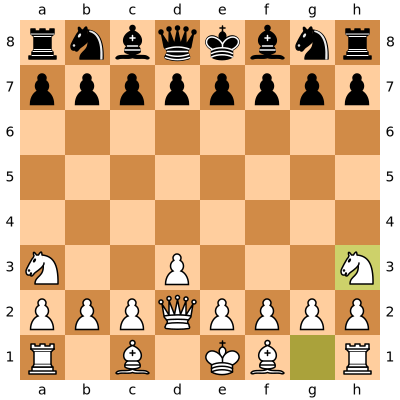

In [ ]:
env.board

In [ ]:
episode_reward_history

[100]